# Hill Climbing (with adaptive noise scaling)

---

   In this notebook, we train the Hill Climbing Agent with   
**adaptive noise scaling** with OpenAI Gym's Cartpole environment.

### Policy-Based Method

In **policy-based methods**, instead of learning a **value function** that tells us what is     
the expected sum of rewards given a state and an action, we learn directly the **policy function**    
that maps state to action (select actions without using a value function).

### 1. Import the Necessary Packages

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
#%matplotlib inline


### 2. Define the Policy

In [2]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

class Policy():
    def __init__(self, s_size=4, a_size=2):
        self.w = 1e-4*np.random.rand(s_size, a_size)  # weights for simple linear policy: state_space x action_space
        
    def forward(self, state):
        x = np.dot(state, self.w)
        return np.exp(x)/sum(np.exp(x))
    
    def act(self, state):
        if isinstance(state, tuple):
            state = state[0]
        probs = self.forward(state)
        #action = np.random.choice(2, p=probs) # option 1: stochastic policy
        action = np.argmax(probs)              # option 2: deterministic policy
        return action

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


/Users/marek.vetter/Library/Caches/pypoetry/virtualenvs/cartpole-cjUCt48w-py3.10/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


### 3. Train the Agent with Stochastic Policy Search

In [155]:
env = gym.make('CartPole-v0')
# env.seed(0)
np.random.seed(0)

policy = Policy()

def hill_climbing(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100, noise_scale=1e-2):
    """Implementation of hill climbing with adaptive noise scaling.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    for i_episode in range(1, n_episodes+1):
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action = policy.act(state)
            state, reward, done, truncated, info = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        if R >= best_R: # found better weights
            best_R = R
            best_w = policy.w
            noise_scale = max(1e-3, noise_scale / 2)
            policy.w += noise_scale * np.random.rand(*policy.w.shape) 
        else: # did not find better weights
            noise_scale = min(2, noise_scale * 2)
            policy.w = best_w + noise_scale * np.random.rand(*policy.w.shape)

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            policy.w = best_w
            break
        
    return scores
            
scores = hill_climbing()

Environment solved in 1 episodes!	Average Score: 215.00


### 4. Plot the Scores

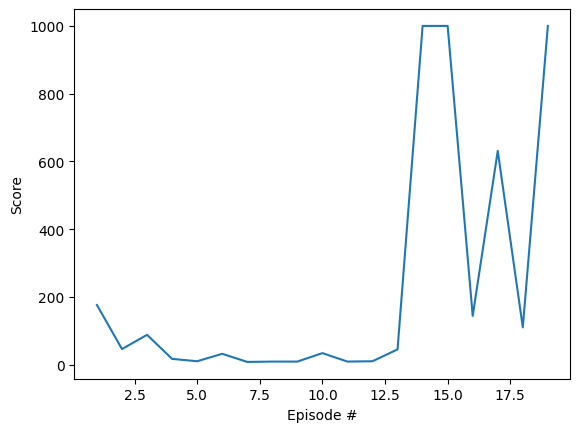

In [145]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

Each step of the Smart Agent animation includes the cl of the following _action_, _state_ and _reward_.     
This also includes a slight _delay_ (0.1 sec) for better observation of the animation, and  further rendering.

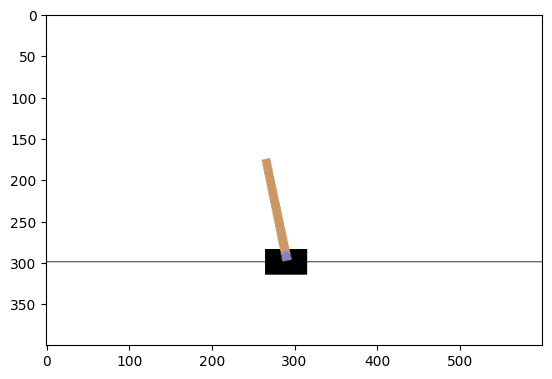

In [159]:
import time

env = gym.make('CartPole-v0', render_mode="rgb_array")
state = env.reset()
img = plt.imshow(env.render())
# img = plt.imshow(env.render(mode='rgb_array'))
# for t in range(200):
for t in range(2000):
    action = policy.act(state)
    env.render()
    time.sleep(0.1)
    state, reward, done, truncated, info = env.step(action)
    if done:
        break 

env.close()